# 1. Libaries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score

from models.EFM import Ethereum_Fraud_Model
# from models.RF import Random_Forest_Model
from models.DBSCAN import DBSCAN_Model
from models.SVM import SVM_Model
from models.LR import Logistic_Regression_Model
from models.GMM import GMM_Model
from models.PCA import PCA_Transformer
from utils.correlation import get_top_abs_correlations

from config import *
from utils.cleaner import *

# 2. Data Reading

In [2]:
efm = Ethereum_Fraud_Model()
print(efm.df.shape)
display(efm.df.head())

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
1710,1711,0x2cd13eabb20a684040e46dff61af4df5279908ea,0,0.00,2638.14,195222.03,0,74,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,None,OmiseGO
101,102,0x00f3c39b641a3533b95dd30b4f5b3a87ba9044ca,0,3.62,0.00,10.87,3,2,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
6670,3738,0xb21b3417daa58b886b5eb13480533516cbf6779f,0,8.49,0.00,16.98,2,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2599,2600,0x43e896e6d0fb3d45b13cbafc739e210a9b3150cf,0,0.00,6941.22,319295.95,0,46,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,None,DATAcoin
4652,1720,0x7bb3e7da45200c07f085c0daed8ba24fbcf18550,0,105.16,0.00,315.47,3,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


# 3. Data Exploration

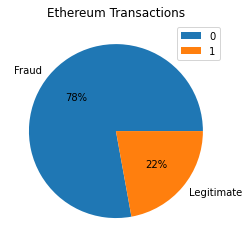

In [3]:
df = efm.df.copy()
flag_counts = df['FLAG'].value_counts()

plt.pie(flag_counts, labels={'Fraud', 'Legitimate'}, autopct='%.0f%%')
plt.title('Ethereum Transactions')
plt.legend(flag_counts.keys().tolist())
plt.show()

In [4]:
# Removing features based on Domain Understanding
df.drop(efm.filtered_colns, axis=1, inplace=True)

In [5]:
# Get features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64




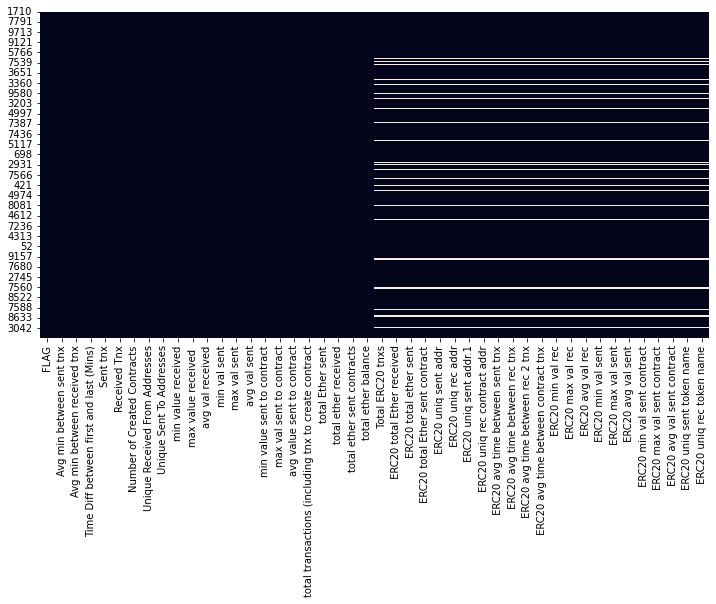

In [6]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

<AxesSubplot:>

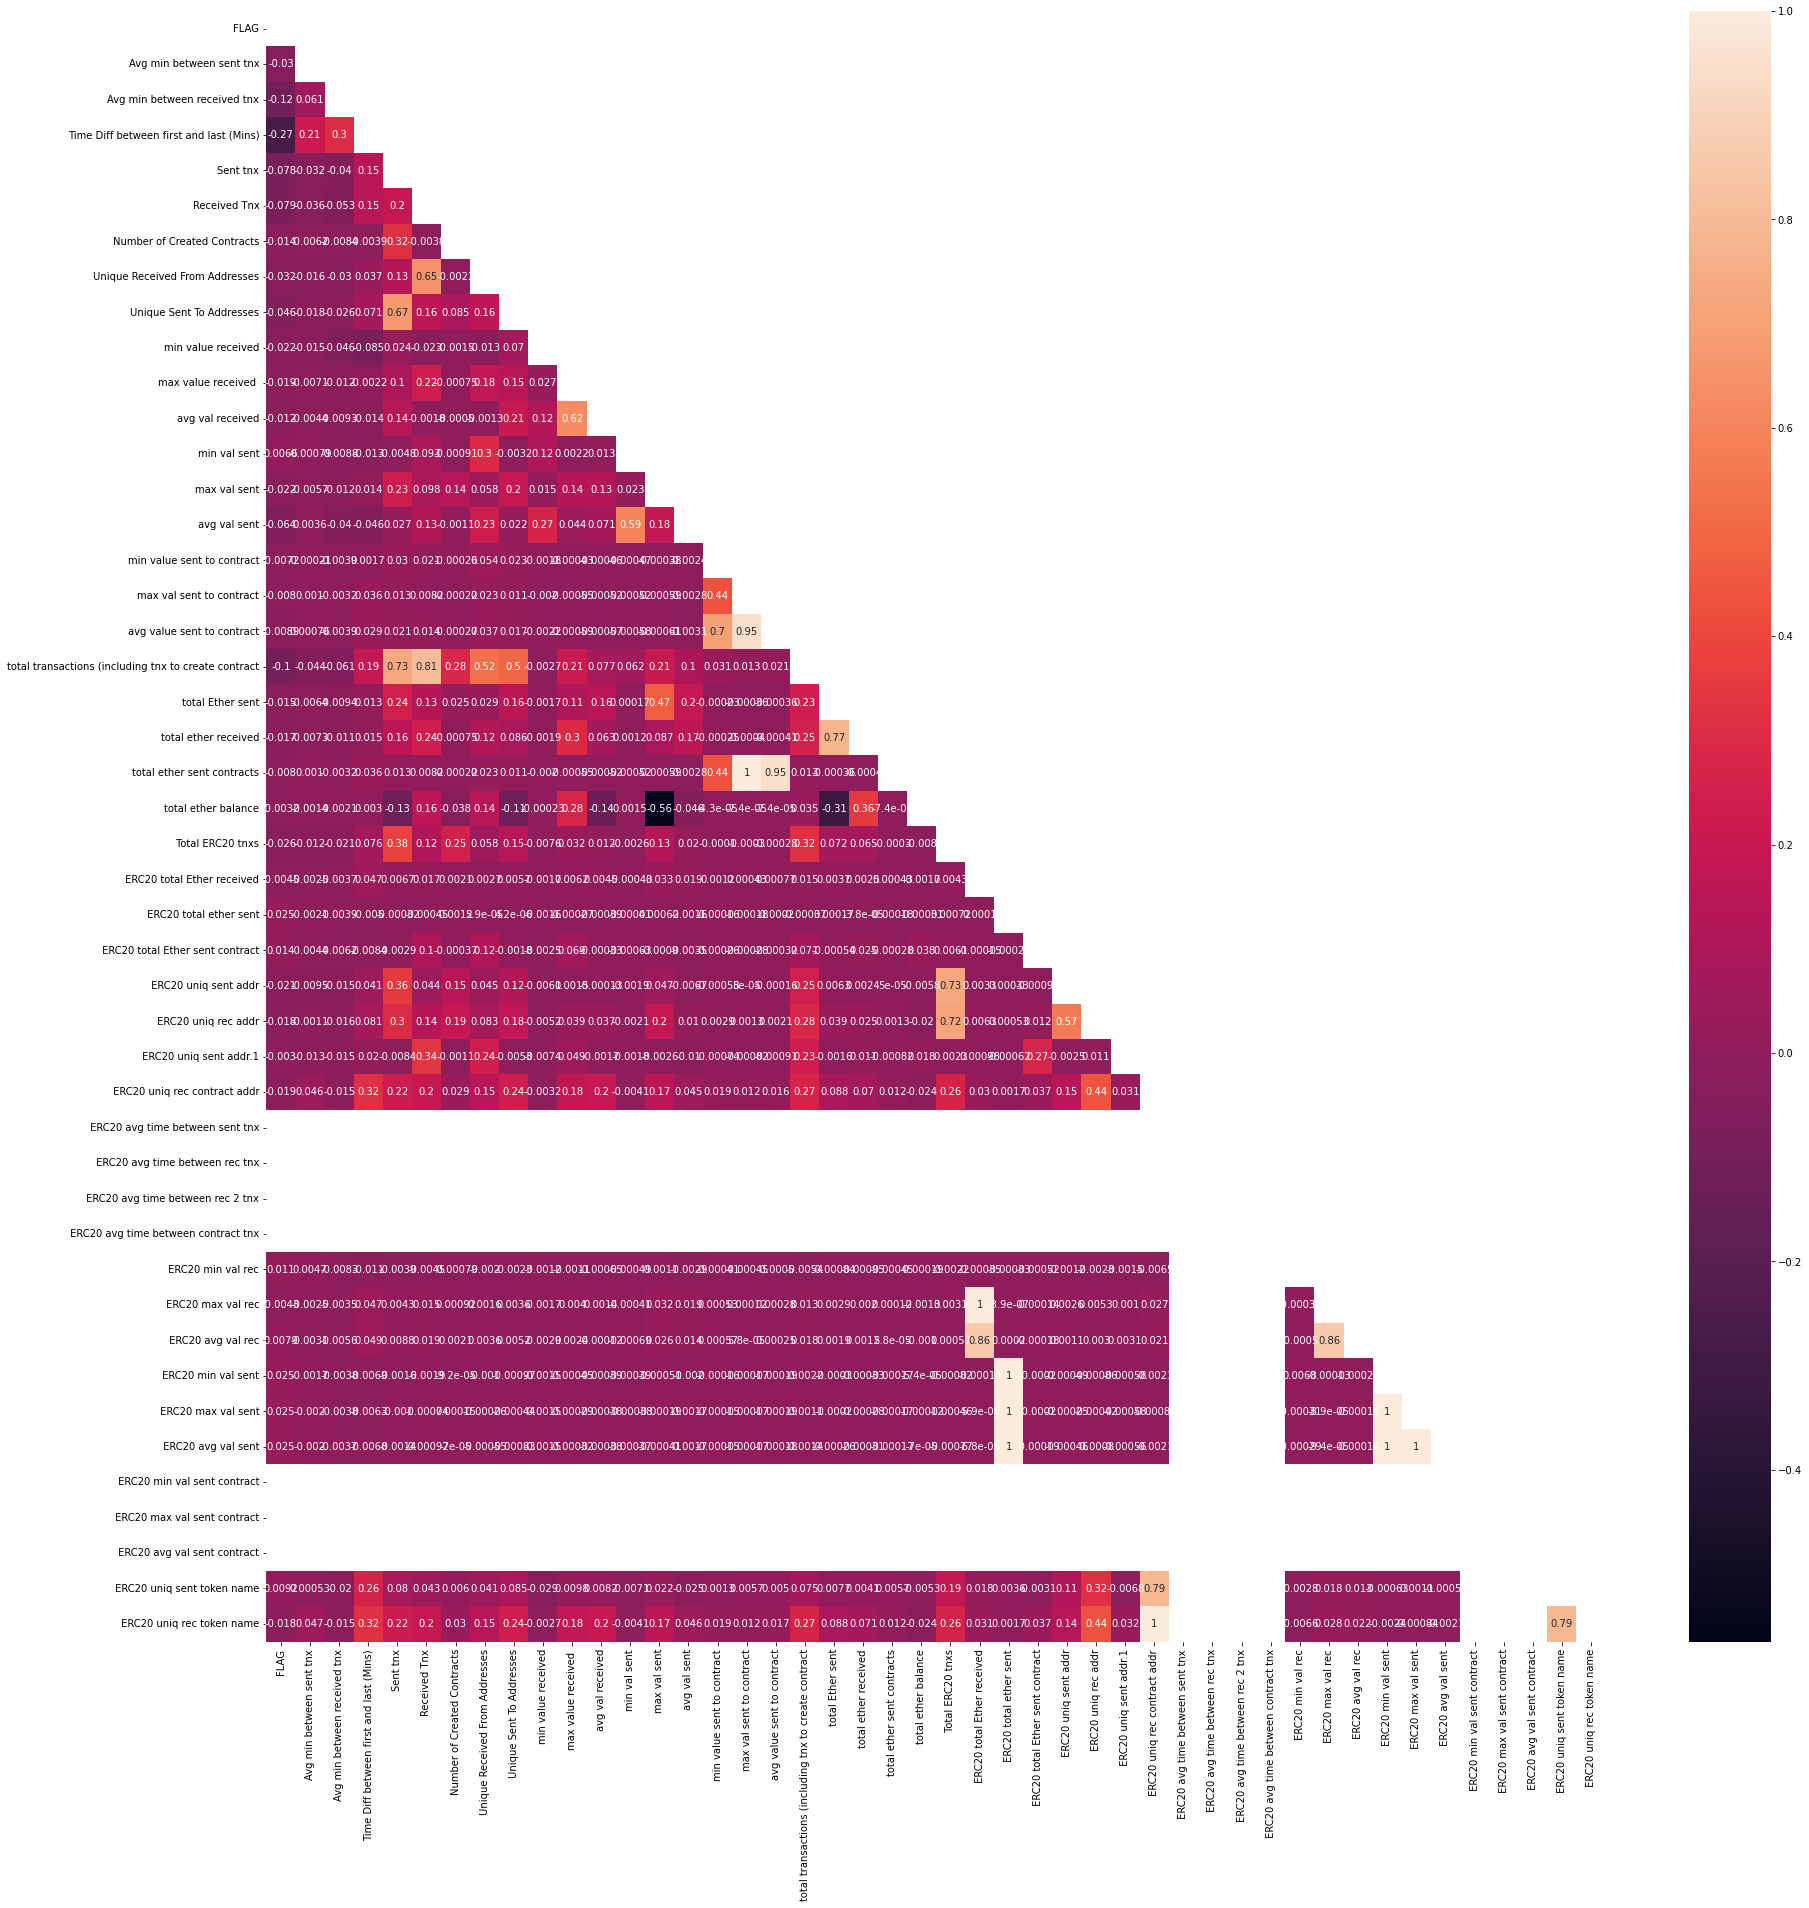

In [7]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(30,30))
sns.heatmap(df.corr(), mask=mask, annot=True)

In [8]:
high_corr_colns = get_top_abs_correlations(df)
print(high_corr_colns)

max val sent to contract       total ether sent contracts    1.000000
 ERC20 total Ether received     ERC20 max val rec            0.999967
 ERC20 max val sent             ERC20 avg val sent           0.999952
 ERC20 min val sent             ERC20 avg val sent           0.999785
                                ERC20 max val sent           0.999729
 ERC20 total ether sent         ERC20 max val sent           0.999649
 ERC20 uniq rec contract addr   ERC20 uniq rec token name    0.999642
 ERC20 total ether sent         ERC20 avg val sent           0.999566
                                ERC20 min val sent           0.999311
avg value sent to contract     total ether sent contracts    0.949608
dtype: float64


In [9]:
# Find features with correlation greater than 0.95
corr_colns = [column for column in upper.columns if any(upper[column] >0.95)]
print(corr_colns)

# Drop Columns with correlation greater than 0.95
df.drop(corr_colns, axis=1, inplace=True)

['total ether sent contracts', ' ERC20 max val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 uniq rec token name']


# Add Box Plot Analysis

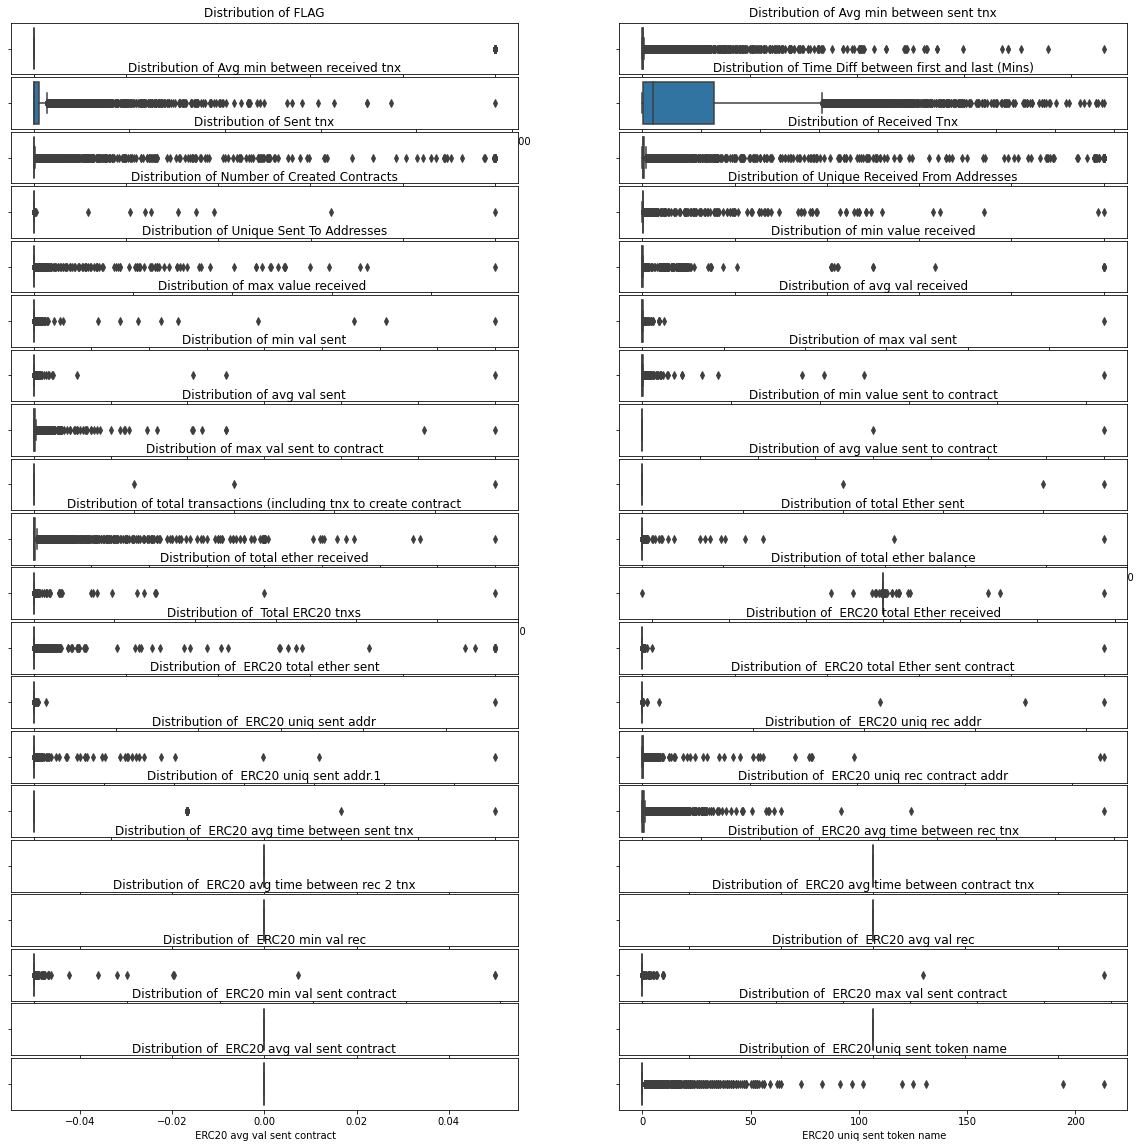

In [10]:
columns = df.columns
fig, axes = plt.subplots(20, 2, figsize=(20, 20), constrained_layout =True)
plt.subplots_adjust(wspace = 0.2, hspace=0.05)

k = 0
for i in range(20):
    for j in range(2):
        sns.boxplot(ax = axes[i,j], data=df, x=columns[k]).set_title(f'Distribution of {columns[k]}')
        k = k+1

plt.show()

# 4. Data Cleaning

In [11]:
print_nan_data(df)

FLAG                                                    0.000000
Avg min between sent tnx                                0.000000
Avg min between received tnx                            0.000000
Time Diff between first and last (Mins)                 0.000000
Sent tnx                                                0.000000
Received Tnx                                            0.000000
Number of Created Contracts                             0.000000
Unique Received From Addresses                          0.000000
Unique Sent To Addresses                                0.000000
min value received                                      0.000000
max value received                                      0.000000
avg val received                                        0.000000
min val sent                                            0.000000
max val sent                                            0.000000
avg val sent                                            0.000000
min value sent to contrac

In [12]:
# Drop missing data observations/rows
df_clean = remove_nan_rows(df)
print_nan_data(df_clean)

FLAG                                                    0.0
Avg min between sent tnx                                0.0
Avg min between received tnx                            0.0
Time Diff between first and last (Mins)                 0.0
Sent tnx                                                0.0
Received Tnx                                            0.0
Number of Created Contracts                             0.0
Unique Received From Addresses                          0.0
Unique Sent To Addresses                                0.0
min value received                                      0.0
max value received                                      0.0
avg val received                                        0.0
min val sent                                            0.0
max val sent                                            0.0
avg val sent                                            0.0
min value sent to contract                              0.0
max val sent to contract                

In [13]:
# Drop missing data features/columns
# df_clean = remove_nan_columns(df)

In [14]:
# Removing features with 0 variance
print(df_clean.shape)
df_clean.drop(df_clean.var()[no_var].index, axis = 1, inplace = True)
print(df_clean.var())
print(df_clean.shape)

(9012, 40)
FLAG                                                    1.273743e-01
Avg min between sent tnx                                4.900880e+08
Avg min between received tnx                            5.609860e+08
Time Diff between first and last (Mins)                 1.098688e+11
Sent tnx                                                6.248215e+05
Received Tnx                                            9.631088e+05
Number of Created Contracts                             2.184618e+04
Unique Received From Addresses                          9.729480e+04
Unique Sent To Addresses                                7.594203e+04
min value received                                      1.130904e+05
max value received                                      1.847689e+08
avg val received                                        9.085309e+06
min val sent                                            2.097398e+04
max val sent                                            4.797736e+07
avg val sent           

In [16]:
corr_matrix = df_clean.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

corr_colns = [column for column in upper.columns if any(upper[column] >0.95)]

# Drop Columns with correlation greater than 0.95
df.drop(corr_colns, axis=1, inplace=True)

[]

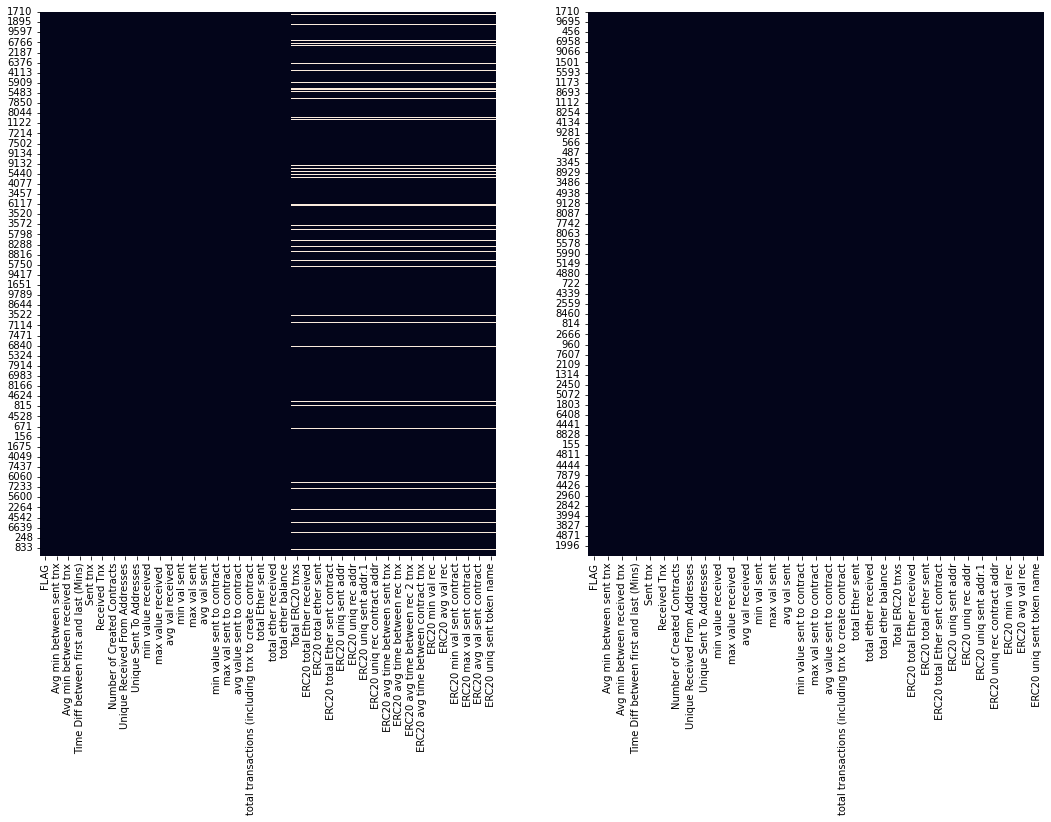

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

sns.heatmap(df.isnull(), cbar=False, ax=ax1)
sns.heatmap(df_clean.isnull(), cbar=False, ax=ax2)
ax1.plot()
ax2.plot()

[]

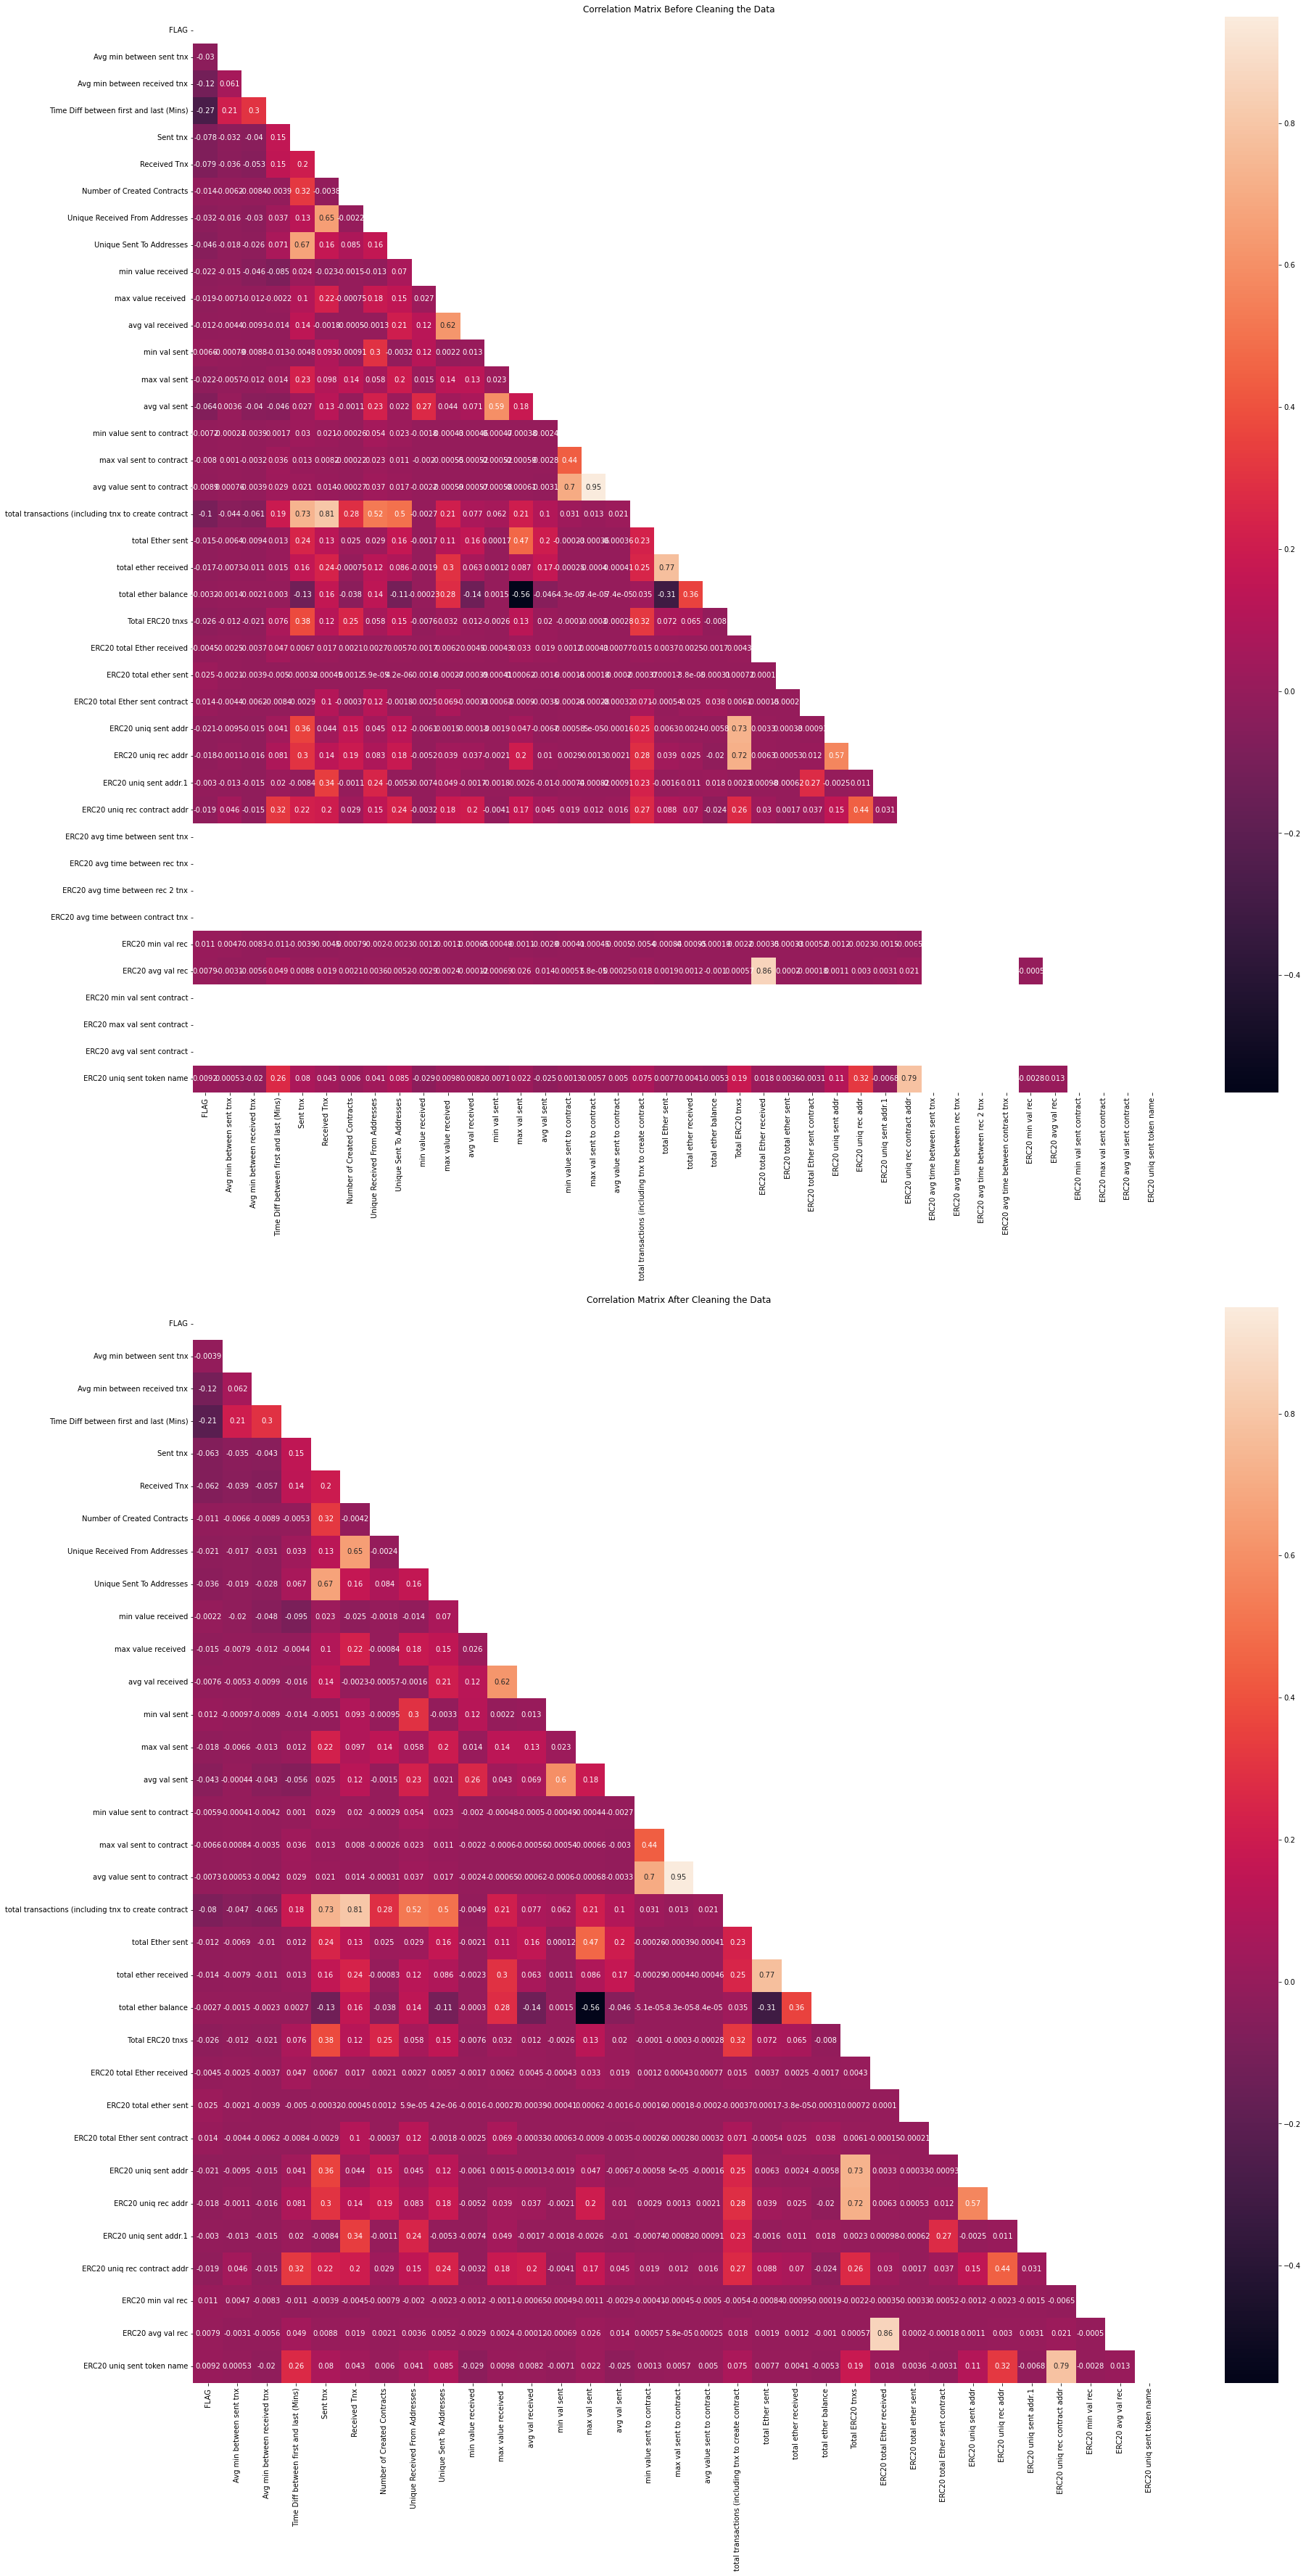

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 60))

corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]=True

sns.heatmap(df.corr(), mask=mask, annot=True, ax=ax1)

corr_matrix = df_clean.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]=True

sns.heatmap(df_clean.corr(), mask=mask, annot=True, ax=ax2)

ax1.set_title('Correlation Matrix Before Cleaning the Data')
ax1.plot()
ax2.set_title('Correlation Matrix After Cleaning the Data')
ax2.plot()

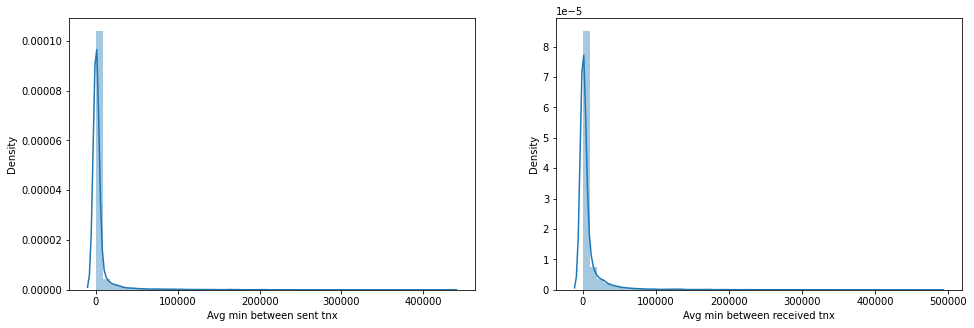

In [19]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['Avg min between sent tnx'])
plt.subplot(1,2,2)
sns.distplot(df['Avg min between received tnx'])
plt.show()

# 5. Data Preparation

In [20]:
# Normalizae Data
df_norm = df_clean.copy()

# apply normalization techniques
for column in df_norm.columns:
    # We don't want to apply normalization on TARGET column
    if column == TARGET:
        continue
    df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())

df_norm.dropna(inplace=True, axis=1)

In [21]:
display(df_norm)

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 avg val rec,ERC20 uniq sent token name
1710,0,0.000000,0.005471,0.099865,0.0000,0.0074,0.0001,0.0002,0.000000,0.000000,...,1.777917e-12,0.0,0.0,0.0,0.000233,0.0,0.001279,1.795911e-06,1.031186e-10,0.0
101,0,0.000008,0.000000,0.000006,0.0003,0.0002,0.0000,0.0002,0.000323,0.043751,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0
6670,0,0.000020,0.000000,0.000009,0.0002,0.0001,0.0000,0.0001,0.000215,0.002809,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0
2599,0,0.000000,0.014396,0.163334,0.0000,0.0046,0.0001,0.0004,0.000000,0.000000,...,1.087726e-12,0.0,0.0,0.0,0.000466,0.0,0.002558,4.570596e-07,3.154390e-11,0.0
4652,0,0.000244,0.000000,0.000161,0.0003,0.0001,0.0000,0.0001,0.000215,0.010100,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8566,1,0.000000,0.001351,0.024771,0.0001,0.0017,0.0000,0.0015,0.000108,0.000001,...,1.499970e-09,0.0,0.0,0.0,0.000466,0.0,0.002558,0.000000e+00,4.349891e-08,0.0
696,0,0.130377,0.047413,0.341216,0.0007,0.0012,0.0000,0.0005,0.000215,0.000003,...,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0
9805,1,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,...,1.336973e-11,0.0,0.0,0.0,0.000233,0.0,0.001279,1.350505e-05,7.754406e-10,0.0
2043,0,0.359428,0.000000,0.237343,0.0003,0.0001,0.0000,0.0001,0.000215,0.000169,...,1.272937e-13,0.0,0.0,0.0,0.000233,0.0,0.001279,1.285818e-07,7.382983e-12,0.0


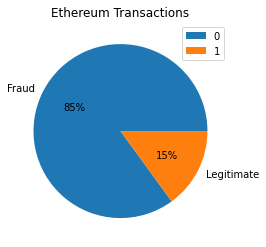

In [22]:
flag_counts = df_norm['FLAG'].value_counts()

plt.pie(flag_counts, labels={'Fraud', 'Legitimate'}, autopct='%.0f%%')
plt.title('Ethereum Transactions')
plt.legend(flag_counts.keys().tolist())
plt.show()

# 6. Sampling

## Method 1. SMOTE Sampling

In [23]:
from utils.sampling import smote

df_smote = df_norm.copy()

X = df_smote.drop(TARGET, axis=1)
y = df_smote[TARGET]
X_res, y_res = smote(X, y, verbose=True)
df_smote = pd.concat([X_res, y_res], axis=1)
display(df_smote.head())

Original Data Distribution:  Counter({0: 7662, 1: 1350})
Data Distribution After SMOTE:  Counter({0: 7662, 1: 7662})


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 avg val rec,ERC20 uniq sent token name,FLAG
0,0.000000,0.005471,0.099865,0.0000,0.0074,0.0001,0.0002,0.000000,0.000000,0.000028,...,0.0,0.0,0.0,0.000233,0.0,0.001279,1.795911e-06,1.031186e-10,0.0,0
1,0.000008,0.000000,0.000006,0.0003,0.0002,0.0000,0.0002,0.000323,0.043751,0.001954,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0
2,0.000020,0.000000,0.000009,0.0002,0.0001,0.0000,0.0001,0.000215,0.002809,0.000035,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0
3,0.000000,0.014396,0.163334,0.0000,0.0046,0.0001,0.0004,0.000000,0.000000,0.000001,...,0.0,0.0,0.0,0.000466,0.0,0.002558,4.570596e-07,3.154390e-11,0.0,0
4,0.000244,0.000000,0.000161,0.0003,0.0001,0.0000,0.0001,0.000215,0.010100,0.000126,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0


## Method 2. 3-Way cross validation

# 7. Modeling

## Model 1. Supervised: Random Forest

In [24]:
df_rfm = df_smote.copy()
rfm = Random_Forest_Model(df_rfm)
rfm.set_max_depth(100)
efm.add_model(rfm)
efm.run_model(model_name='RandomForest')

NameError: name 'Random_Forest_Model' is not defined

## Model 2. Supervised: Logistic Regression

In [25]:
df_lr = df_smote.copy()
df_lr = shuffle(df_lr)
lr = Logistic_Regression_Model(df_lr)
lr.run()

Model Name:  Logistic Regression


TypeError: can only concatenate str (not "int") to str

## Model 3. Supervised: Support Vector Machine (SVM)

Model Name:  SVM
Accuracy: 0.7066884176182708
F1 score: 0.7499304589707928
AUPRC: 0.814602107254841
Accuracy: 0.73278955954323
F1 score: 0.7764127764127764
AUPRC: 0.8289941743422757
Accuracy: 0.7066884176182708
F1 score: 0.7504857063558146
AUPRC: 0.8391905716426614
Accuracy: 0.7380097879282218
F1 score: 0.771420438371762
AUPRC: 0.8371298664355001
Accuracy: 0.7199738903394256
F1 score: 0.7632450331125827
AUPRC: 0.8461617088928348


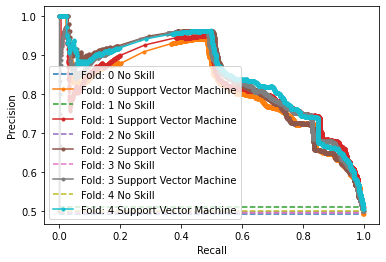

Token Counts accuracy score:  0.7208300146094838
Token Counts precision score:  0.6638090147467348
Token Counts recall score:  0.8952446029237819
Token Counts f1 score:  0.7622988826447458
Token Counts aurpc score:  0.8332156857136226


In [26]:
from sklearn import svm

df_svm = df_smote.copy()
svm_model = SVM_Model(df_svm)
svm_model.run()

## Principal Component Analysis

In [27]:
pca_transformer = PCA_Transformer(df_smote)
pca_transformer.set_n_components(10)
df_pca = pca_transformer.run()

display(df_pca)

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,FLAG
0,-0.242803,0.025658,-0.006972,-0.052973,-0.111925,0.249594,-0.106090,-0.267696,0.317434,-0.156076,0
1,0.054655,0.550142,-0.820718,0.903011,0.652719,-1.135819,0.963072,-0.402866,0.665813,-0.123987,0
2,-0.397290,0.046064,-0.079582,0.121127,-0.282893,0.028736,0.118075,0.018721,0.185440,-0.130805,0
3,-0.181320,-0.008444,0.057912,-0.120497,0.069384,0.361041,-0.259282,-0.487541,0.459543,-0.186293,0
4,-0.378322,0.063913,-0.108554,0.162187,-0.235372,-0.026512,0.143184,0.018934,0.201305,-0.163838,0
...,...,...,...,...,...,...,...,...,...,...,...
15319,-0.475752,-0.061249,-0.016166,0.184893,-0.362868,-0.230297,0.221176,0.633907,-0.424821,0.180216,1
15320,-0.448624,0.020503,-0.109461,0.201136,-0.313128,-0.349089,0.364799,0.550648,-0.370251,0.194576,1
15321,-0.561284,-0.032211,-0.054087,0.228979,-0.476618,-0.235280,0.292510,0.685706,-0.422062,0.163420,1
15322,-0.560623,-0.032069,-0.054066,0.228586,-0.475157,-0.235065,0.292131,0.683972,-0.421006,0.163239,1


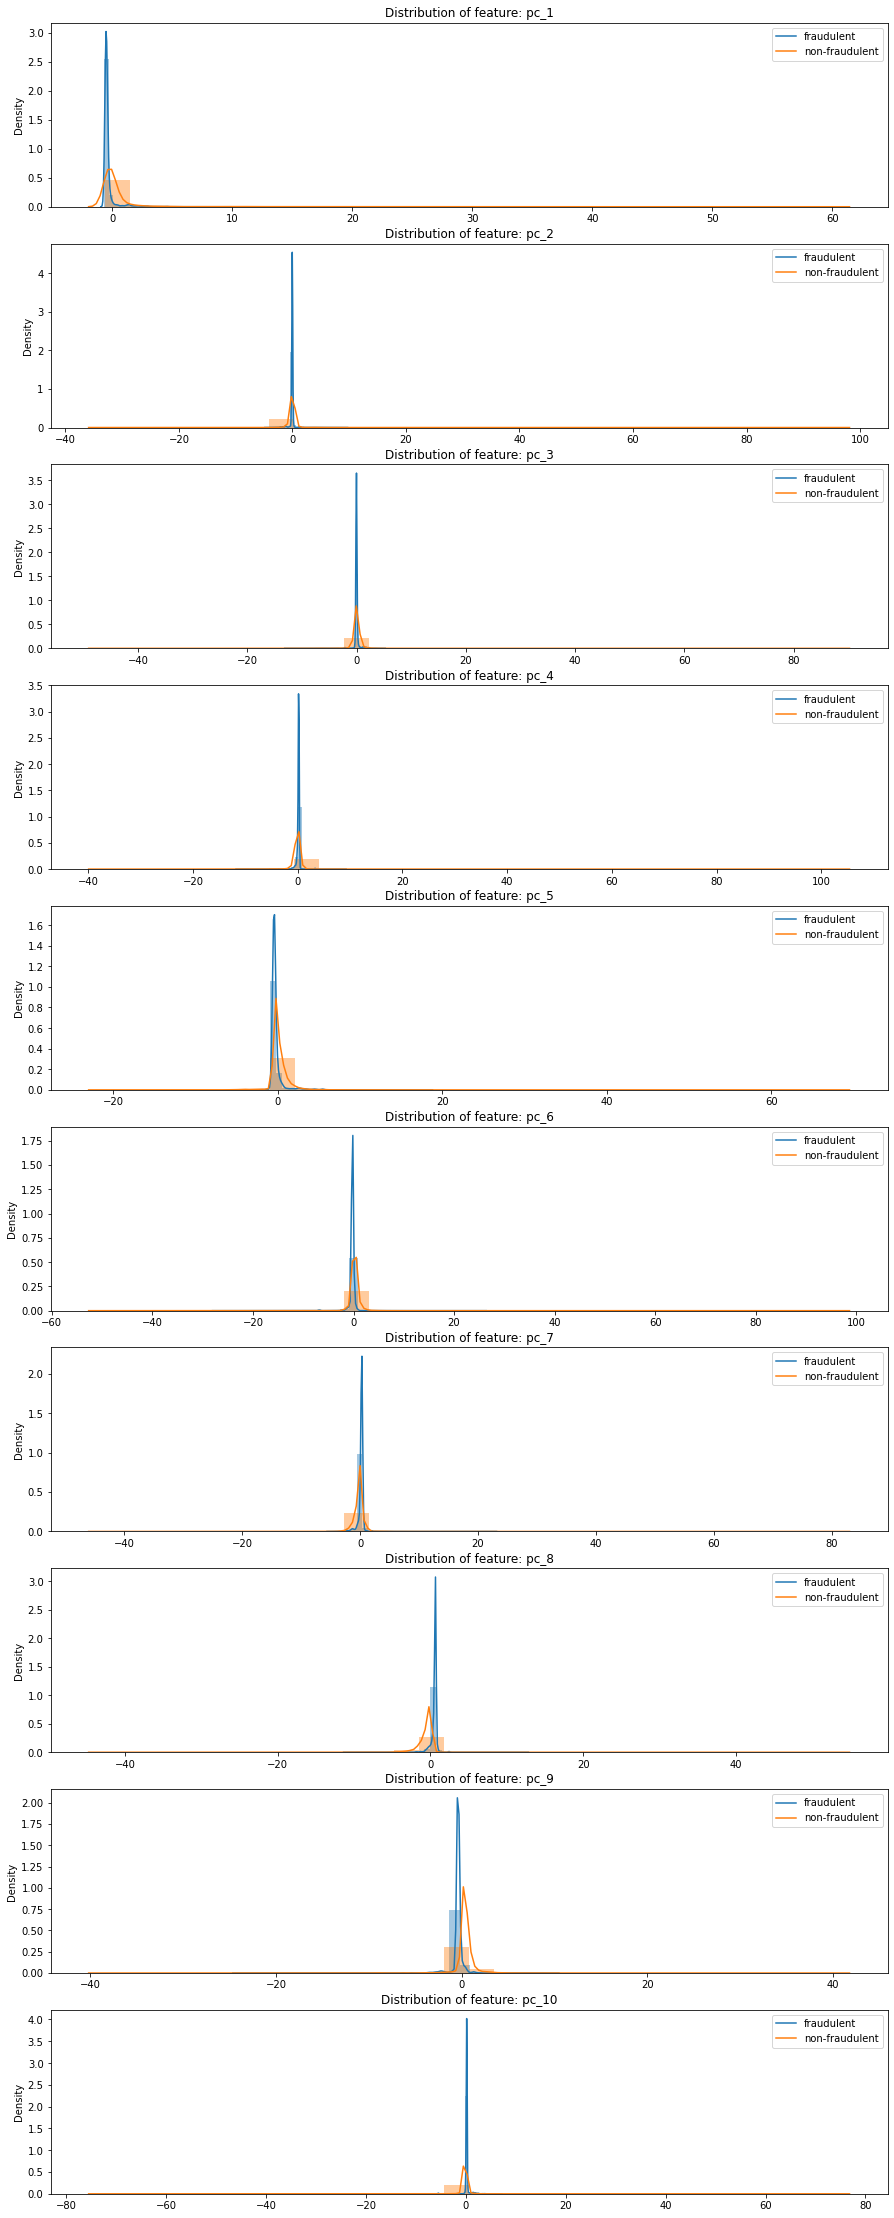

In [28]:
import matplotlib.gridspec as gridspec

features = df_pca.columns

nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    if feat == TARGET:
        continue
    ax = plt.subplot(gs[i])
    sns.distplot(df_pca[feat][df_pca.FLAG==1], bins=30)
    sns.distplot(df_pca[feat][df_pca.FLAG==0], bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Model Name:  SVM
Accuracy: 0.9902120717781403
F1 score: 0.9902407286922575
AUPRC: 0.9991911403509077
Accuracy: 0.9911908646003262
F1 score: 0.9912422964644826
AUPRC: 0.9993724191782112
Accuracy: 0.9892332789559544
F1 score: 0.9893445269615757
AUPRC: 0.9991632607490347
Accuracy: 0.9902120717781403
F1 score: 0.9899799599198397
AUPRC: 0.9987574713504419
Accuracy: 0.991514360313316
F1 score: 0.9913217623497997
AUPRC: 0.9984065975035467


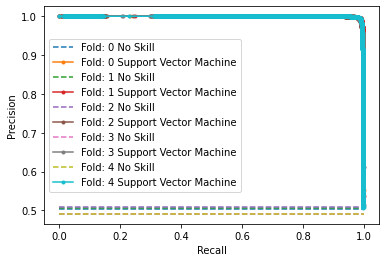

Token Counts accuracy score:  0.9904725294851755
Token Counts precision score:  0.9956518023819452
Token Counts recall score:  0.9852566162921665
Token Counts f1 score:  0.990425854877591
Token Counts aurpc score:  0.9989781778264284


In [29]:
from sklearn import svm

df_svm_2 = df_pca.copy()
svm_model = SVM_Model(df_svm_2)
svm_model.run()

# Modeling After PCA Transformation

## Model 1. Supervised: Random Forest

Highest Accuracy At Depth:  94


1it [00:01,  1.72s/it]

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99      2576
       fraud       0.94      0.97      0.95       489

    accuracy                           0.99      3065
   macro avg       0.97      0.98      0.97      3065
weighted avg       0.99      0.99      0.99      3065

Confusion Matrix: [tn, fp, fn, tp] =  [2544   32   13  476]


2it [00:03,  1.77s/it]

              precision    recall  f1-score   support

      normal       1.00      0.98      0.99      2628
       fraud       0.92      0.99      0.95       437

    accuracy                           0.98      3065
   macro avg       0.96      0.99      0.97      3065
weighted avg       0.99      0.98      0.99      3065

Confusion Matrix: [tn, fp, fn, tp] =  [2588   40    6  431]


3it [00:05,  1.78s/it]

              precision    recall  f1-score   support

      normal       0.99      0.98      0.99      2458
       fraud       0.94      0.98      0.96       607

    accuracy                           0.98      3065
   macro avg       0.97      0.98      0.97      3065
weighted avg       0.98      0.98      0.98      3065

Confusion Matrix: [tn, fp, fn, tp] =  [2419   39   14  593]


4it [00:06,  1.63s/it]

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00         0
       fraud       1.00      0.99      1.00      3065

    accuracy                           0.99      3065
   macro avg       0.50      0.50      0.50      3065
weighted avg       1.00      0.99      1.00      3065

Confusion Matrix: [tn, fp, fn, tp] =  [   0    0   28 3037]


5it [00:08,  1.63s/it]

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00         0
       fraud       1.00      0.99      1.00      3064

    accuracy                           0.99      3064
   macro avg       0.50      0.50      0.50      3064
weighted avg       1.00      0.99      1.00      3064

Confusion Matrix: [tn, fp, fn, tp] =  [   0    0   20 3044]


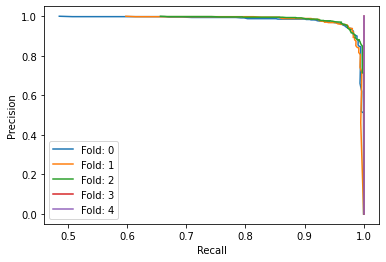

In [22]:
df_rfm_pca = df_pca.copy()
rfm = Random_Forest_Model(df_rfm_pca)
rfm.set_max_depth(100)
efm.add_model(rfm)
efm.run_model(model_name='RandomForest')

## Model 2. Supervised: Logistic Regression

In [30]:
df_lr_pca = df_pca.copy()
df_lr_pca = shuffle(df_lr_pca)
lr = Logistic_Regression_Model(df_lr_pca)
lr.run()

Model Name:  Logistic Regression


TypeError: can only concatenate str (not "int") to str

## Model 3. Supervised: Support Vector Machine (SVM)

Model Name:  SVM
Accuracy: 0.9928221859706362
F1 score: 0.9928292046936115
AUPRC: 0.999509669053349
Accuracy: 0.9895595432300163
F1 score: 0.9891525423728813
AUPRC: 0.9987677269536609
Accuracy: 0.9902120717781403
F1 score: 0.9904336734693878
AUPRC: 0.9985227568537514
Accuracy: 0.9911908646003262
F1 score: 0.9910979228486646
AUPRC: 0.9992806492829849
Accuracy: 0.987597911227154
F1 score: 0.9875573018991487
AUPRC: 0.9985561800560164


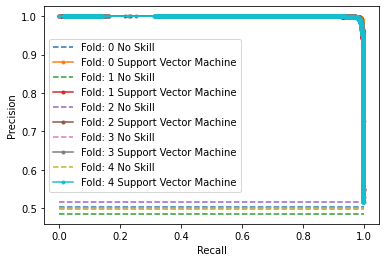

Token Counts accuracy score:  0.9902765153612547
Token Counts precision score:  0.9956428310184388
Token Counts recall score:  0.9848492770496311
Token Counts f1 score:  0.9902141290567388
Token Counts aurpc score:  0.9989273964399524


In [31]:
from sklearn import svm

df_svm_pca = df_pca.copy()
svm_model = SVM_Model(df_svm_pca)
svm_model.run()

## Model 3. Unsupervised: GMM

(9012, 33)
(9012, 33)
-0.5317929299794691
2.6542123635083668


"\nprint(gmm_df[feature1].mean())\nprint(gmm_df[feature1].std())\n\nax[0,0].hist(gmm_df[feature1], bins=100)\nax[0,0].set_title(feature1, fontsize=14)\nax[0,0].set_ylabel('Transactions')\n\nax[0,1].hist(gmm_df[feature2], bins=100)\nax[0,1].set_title(feature2, fontsize=14)\nax[0,1].set_ylabel('Transactions')\n\nax[1,0].hist(gmm_df[feature3], bins=100)\nax[1,0].set_title(feature3, fontsize=14)\nax[1,0].set_ylabel('Transactions')\n\nax[1,1].hist(gmm_df[feature4], bins=100)\nax[1,1].set_title(feature4, fontsize=14)\nax[1,1].set_ylabel('Transactions')\n"

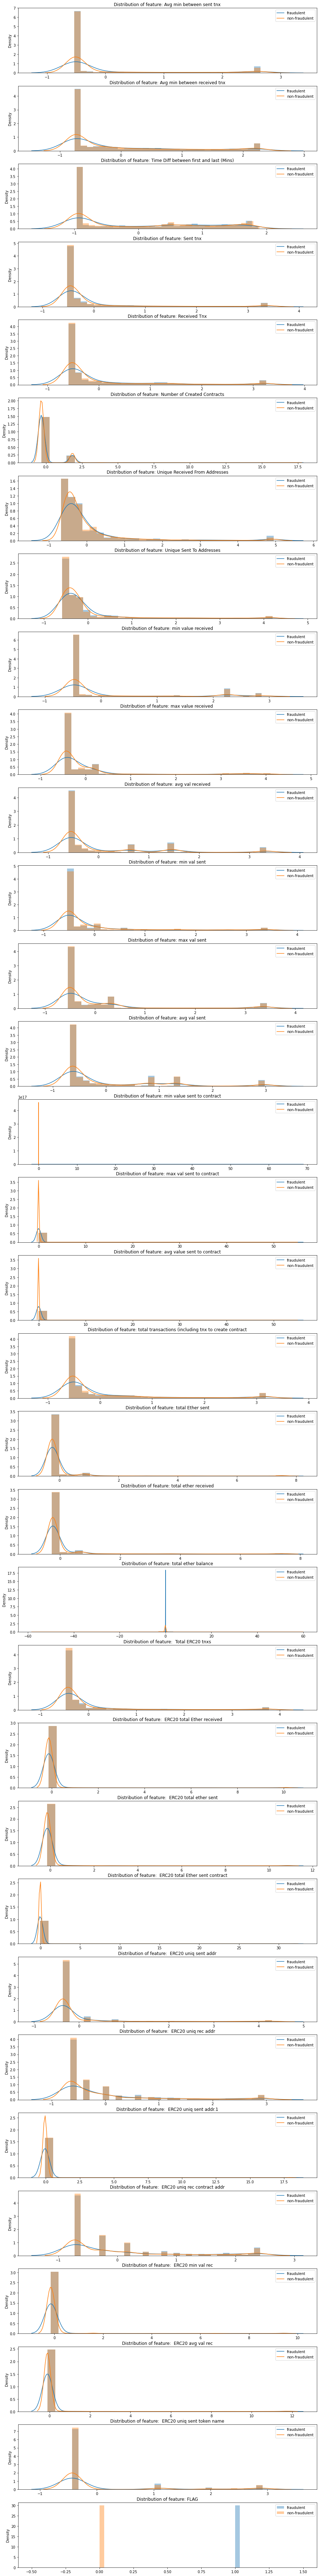

In [15]:
# Trying Standardizing data to get better result with 

from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import PowerTransformer

gmm_df = df_norm.copy().drop(TARGET, axis=1)
gmm_features = gmm_df.columns

# Standardization
# scale= StandardScaler()
# gmm_df = pd.DataFrame(scale.fit_transform(gmm_df), columns=gmm_df.columns)
# gmm_df[TARGET] = df_norm[TARGET]

# print(df_norm.shape)
# print(gmm_df.shape)

# Transform
powerTran = PowerTransformer(method="yeo-johnson")
gmm_df = powerTran.fit_transform(gmm_df)
gmm_df = pd.DataFrame(gmm_df, columns=gmm_features)
gmm_df[TARGET] = df_norm[TARGET]

print(df_norm.shape)
print(gmm_df.shape)

# Draw
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

# features = ['Avg min between sent tnx', 'Avg min between received tnx', 'Sent tnx', 'Received Tnx']
# features = gmm_df.columns

# nplots=np.size(features)
# plt.figure(figsize=(15,4*nplots))
# gs = gridspec.GridSpec(nplots,1)
# for i, feat in enumerate(features):
#     ax = plt.subplot(gs[i])
#     sns.distplot(gmm_df[feat][df.FLAG==1], bins=30)
#     sns.distplot(gmm_df[feat][df.FLAG==0],bins=30)
#     ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
#     ax.set_xlabel('')
#     ax.set_title('Distribution of feature: ' + feat)

# print(gmm_df['Avg min between sent tnx'].min())
# print(gmm_df['Avg min between sent tnx'].max())

'''
print(gmm_df[feature1].mean())
print(gmm_df[feature1].std())

ax[0,0].hist(gmm_df[feature1], bins=100)
ax[0,0].set_title(feature1, fontsize=14)
ax[0,0].set_ylabel('Transactions')

ax[0,1].hist(gmm_df[feature2], bins=100)
ax[0,1].set_title(feature2, fontsize=14)
ax[0,1].set_ylabel('Transactions')

ax[1,0].hist(gmm_df[feature3], bins=100)
ax[1,0].set_title(feature3, fontsize=14)
ax[1,0].set_ylabel('Transactions')

ax[1,1].hist(gmm_df[feature4], bins=100)
ax[1,1].set_title(feature4, fontsize=14)
ax[1,1].set_ylabel('Transactions')
'''

In [14]:
# GMM
# df_gmm = df_smote.copy()
gmm_model = GMM_Model(gmm_df)
gmm_model.run(verbose=True)
# efm.add_model(gmm_model)
# efm.run_model(model_name='GMM', verbose=True)

Model Name: GMM


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 avg val rec,ERC20 uniq sent token name,FLAG
0,-0.531793,2.094861,-0.051626,-0.518305,-0.508159,1.839776,-0.403589,-0.585664,-0.254811,-0.175584,...,-0.139037,-0.033691,-0.359114,-0.652910,-0.055827,-0.727219,-0.154134,-0.110482,-0.433548,0.0
1,-0.447621,-0.761016,-0.956044,-0.461708,-0.546840,-0.319282,-0.403589,-0.323294,-0.266222,0.131955,...,-0.139037,-0.033691,-0.359114,-0.652910,-0.055827,-0.727219,-0.154134,-0.110482,-0.433548,0.0
2,-0.449949,-0.761010,-0.956131,-0.461708,-0.546840,-0.319282,-0.403589,-0.323294,1.389503,-0.135897,...,-0.139037,-0.033691,-0.359114,-0.652910,-0.055827,-0.727219,-0.154134,-0.110482,-0.433548,0.0
3,-0.438902,-0.743496,1.743832,3.387629,-0.469880,-0.319282,-0.272815,4.198136,-0.490666,-0.436341,...,-0.139037,-0.033691,4.297757,2.967423,-0.055827,2.357198,-0.154134,0.829683,1.106962,0.0
4,-0.531793,-0.451342,-0.920069,-0.489902,-0.546840,-0.319282,-0.403589,-0.452624,-0.424852,-0.456467,...,-0.139037,-0.033691,-0.359114,-0.652910,-0.055827,-0.727219,-0.154134,-0.110482,-0.433548,0.0


Components: 1
GMM Score for train set
-22.336911093543854
GMM Score for normal transcation subset in validation set
-21.370567655345116
GMM Score for fraud transcation subset in validation set
-31.548860407971322
0.506344410876133 99
The final threshold selected is:  0.0
Final threshold: 0.000000
Test Recall Score: 1.000
Test Precision Score: 0.339
Test F1 Score: 0.506
tn, fp, fn, tp: [  0 818   0 419]
Components: 2
GMM Score for train set
38.19756356482751
GMM Score for normal transcation subset in validation set
41.10082353017954
GMM Score for fraud transcation subset in validation set
36.12380595416609
0.2682926829268293 96
The final threshold selected is:  -24.24242424242425
Final threshold: -24.242424
Test Recall Score: 0.210
Test Precision Score: 0.406
Test F1 Score: 0.277
tn, fp, fn, tp: [689 129 331  88]
Components: 3
GMM Score for train set
58.147956360290664
GMM Score for normal transcation subset in validation set
61.9366283015268
GMM Score for fraud transcation subset in va

## Model 4. Unsupervised: DBSCAN

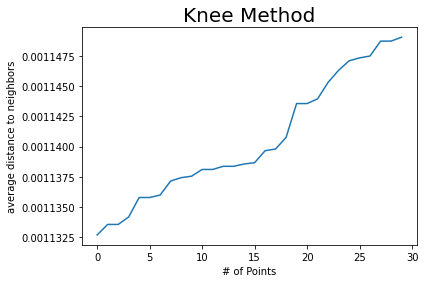

EPS 0.0011381001685537542
Estimated number of clusters: 214
Estimated number of Noise Points: 6662
EPS 0.0011381001685537542
Estimated number of clusters: 214
Estimated number of Noise Points: 6662
EPS 0.001138361974542792
Estimated number of clusters: 214
Estimated number of Noise Points: 6662
EPS 0.001138361974542792
Estimated number of clusters: 214
Estimated number of Noise Points: 6662
EPS 0.001138553570403505
Estimated number of clusters: 214
Estimated number of Noise Points: 6659
EPS 0.0011386614708195563
Estimated number of clusters: 215
Estimated number of Noise Points: 6655
EPS 0.0011396568707737976
Estimated number of clusters: 215
Estimated number of Noise Points: 6653
EPS 0.0011398002116178982
Estimated number of clusters: 215
Estimated number of Noise Points: 6653
EPS 0.0011407605186887926
Estimated number of clusters: 215
Estimated number of Noise Points: 6653
EPS 0.001143575009746082
Estimated number of clusters: 215
Estimated number of Noise Points: 6652
EPS 0.00114357

In [26]:
# DBSCAN Model
df_dbscan = df_smote.copy()
dbscan_model = DBSCAN_Model(df_dbscan)
efm.add_model(dbscan_model)
efm.run_model(model_name='DBSCAN')

# 8. Model Evaluation (by Kenny)

### -------------------- Functions Delarations --------------------

In [ ]:
# Helper: compute corresponding f1-score given thresholds
def compute_f1(y_test, y_pred, thresholds):
    scores = []
    for th in thresholds:
        th_y_pred = y_pred.copy()
        
        th_y_pred[th_y_pred >= th] = 0
        th_y_pred[th_y_pred < th] = 1
        scores.append(f1_score(y_test, th_y_pred))
    return scores


def plot_ROC(y_test, y_pred, plt_config, f1=False):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('ROC for ' + plt_config['model'])
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0,1], [0,1], 'y--')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('True Positive Rate / Score')
    plt.xlabel('False Positive Rate / Threshold')
    plt.legend(['ROC', 'Perfect Classifier', 'F1'])
    plt.show()


def plot_PRC(y_test, y_pred, plt_config, f1=False):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('PRC for ' + plt_config['model'])
    plt.plot(recall, precision, 'b')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('Precision / Score')
    plt.xlabel('Recall / Threshold')
    plt.legend(['PRC', 'F1'])
    plt.show()


## Metric 1. ROC w/ F1

In [ ]:
# Prepare parameters for ROC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_ROC(y_test, pred, plt_config, f1=True)
"""

## Metric 2. PRC w/ F1

In [ ]:
# Prepare parameters for PRC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_PRC(y_test, pred, plt_config, f1=True)
"""